<a href="https://colab.research.google.com/github/MiaooZheng/CryptoPricePrediction/blob/main/datasci3ml_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.1 import datset

**Note: The model result may change for each run. ***



In [ ]:
import json
import requests
import pprint
import pandas as pd
import datetime
import os

# reference: https://www.cryptocompare.com/cryptopian/api-keys
# for mac, use export Apikey='xxx' to save credentials

api_key = os.getenv('Apikey')
print(api_key)


def extract_data(api_key):
    # here we do CAD as currency and choose binance coin as our cryptocurrency to predict with 1500 rows
    url = 'https://min-api.cryptocompare.com/data/v2/histoday?fsym=BNB&tsym=CAD&limit=1500'
    headers = {
        "Connection": "keep-alive",
        "Apikey": api_key
    }
    response = requests.get(url = url, headers = headers)
    # pprint.pprint(response.json())
    # raw_data = response.json()
    data = json.loads(response.text)['Data']['Data']
    pprint.pprint(data)
    df = pd.DataFrame.from_dict(pd.json_normalize(data), orient='columns')
    # convert epoch time to datetime
    df['time'] = df['time'].apply(lambda d: datetime.datetime.fromtimestamp(int(d)).strftime('%Y-%m-%d'))
    df = df.drop(columns = ['conversionType', 'conversionSymbol'], axis=1)
    print(df.shape)
    df.to_csv('datasci3ml_final_project_dataset.csv')
    return 'save the dataset successfully!'


def read_dataset():
    dataset = pd.read_csv('datasci3ml_final_project_dataset.csv')
    print(dataset.head(10))
    print(dataset.tail(10))

# read_dataset()

# reference: https://www.kaggle.com/code/meetnagadia/bitcoin-price-prediction-using-lstm
# i extracted csv file in vscode, this cell is just for referenceß

for this project, we're planning to predict the price ternd of Binance.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving datasci3ml_final_project_dataset.csv to datasci3ml_final_project_dataset.csv


In [ ]:
import io
import pandas as pd
data = pd.read_csv(io.BytesIO(uploaded['datasci3ml_final_project_dataset.csv']))
data.tail(5)

,Unnamed: 0,time,high,low,open,volumefrom,volumeto,close
1496,1496,2023-01-29,412.69,401.98,421.48,63638.22,26184957.28,411.47
1497,1497,2023-01-30,422.65,411.87,411.68,35867.33,14916777.79,415.89
1498,1498,2023-01-31,432.74,419.88,415.89,41991.07,17677112.59,420.97
1499,1499,2023-02-01,437.02,414.50,420.97,77902.99,33516999.87,430.24
1500,1500,2023-02-02,452.48,424.02,430.08,95250.81,42098481.32,441.98


In [ ]:
# import related packages
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [ ]:
data.shape

(1501, 8)

In [ ]:
data.columns[7:]

Index(['close'], dtype='object')

Text(0, 0.5, 'Close Prices ($)')

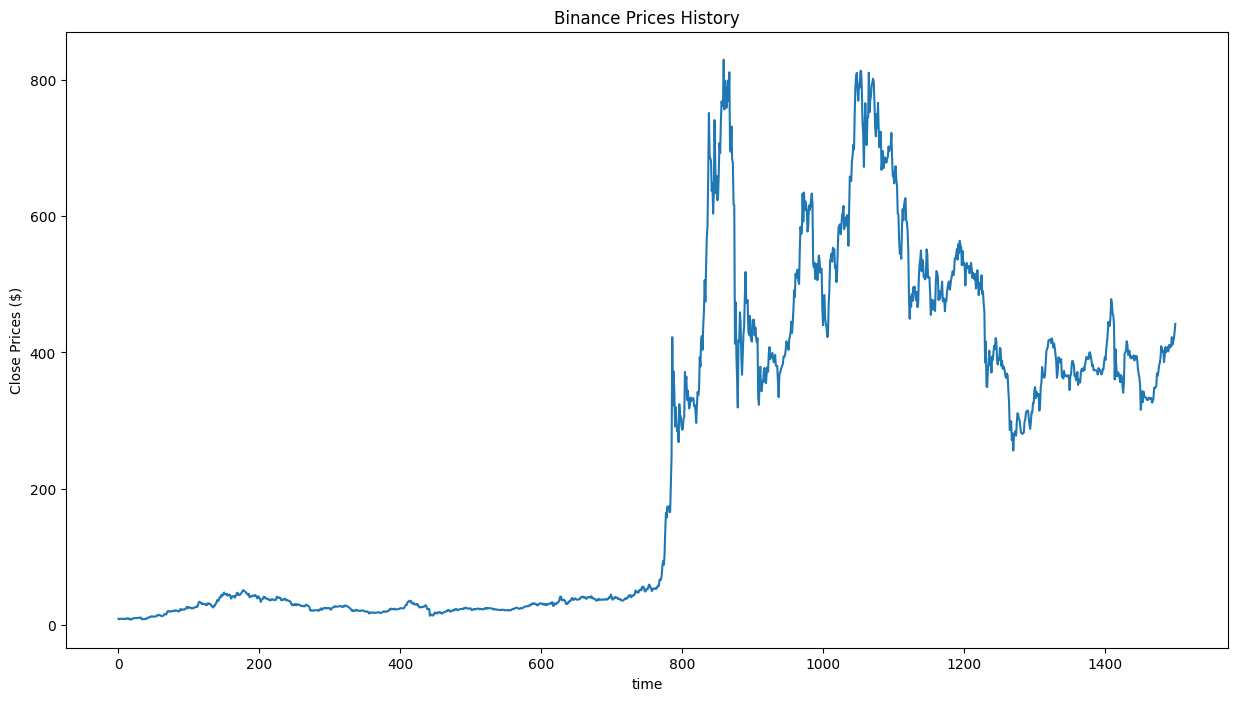

In [ ]:
# first we're going to check the close price trend
plt.figure(figsize=(15, 8))
plt.title('Binance Prices History')
plt.plot(data['close'])
plt.xlabel('time')
plt.ylabel('Close Prices ($)')

from above, we can see the price change is dramatic, we may need take some actions

**I'll try adam as our optimization algorithms first, which is the most common optimizer when we analyse and predict time-series dataset ***

- note, when i write final essay, explain the advantages of adam. 

First, we'll only consider close price as our feature

In [ ]:
# here we only consider close price as feature
close_prices = data['close']

values = close_prices.values # we only want to extract close price our input here for test
print(len(values))

training_data_total = math.ceil(len(values)* 0.8) # let first 80% as train datset - here we extract first 1200 as train set 
print(training_data_total)

train = values[0:1201]
test = values[1201:]
print(len(test))

scaler = MinMaxScaler(feature_range=(0,1)) # first we want to normalize the features, then every feature is in the same scale
scaled_data = scaler.fit_transform(values.reshape(-1,1)) # to reshape values into 2d vector
train_data = scaled_data[0: training_data_total, :]

x_train = []
y_train = []

# use for loop, we can extract continuous close price (subset) as train set and then treat day 61 as label

# but here the question is we extract the first 60 day's true value, not the prediction, meaningless?
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape)


1501
1201
300
(1141, 60, 1)


here we choose 60 days as window period, which is very common to use in RNN to predict price. 

In [ ]:
test_data = scaled_data[training_data_total-60: , :]
x_test = []
y_test = values[training_data_total: ]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) # here we only have 1 feature - close price, then we put 1 at the end.


Then we'll run several models to test the performance - LSTM with different hyperparameters

In [ ]:
# Then create a Sequential model and add layers one at a time to check
model = tf.keras.Sequential()
# the first layer can receive an `input_shape` argument - here we only has close_price 1 feature 
# Fully connected layers are defined using the Dense class. You can specify the number of neurons or nodes in the layer as the first argument and the activation function using the activation argument. (reference)

# our input shape here is (60,1) - the first 60 days with close price 

########.  TEST 1 - LSTM(100)
# activation function = tanh as default below
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1)) # since we want a single continuous output
model.summary()

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
mse = mean_squared_error(y_test, predictions)


print(f'Mean Squared Error is {mse}')
print(f'rmse is {rmse}')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
1141/1141 [==============================] - 51s 41ms/step - loss: 0.0035
Epoch 2/3
1141/1141 [==============================] - 50s 44ms/step - loss: 0.0016
Epoch 3/3
10/1

<ipython-input-10-2daca1eaf33d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


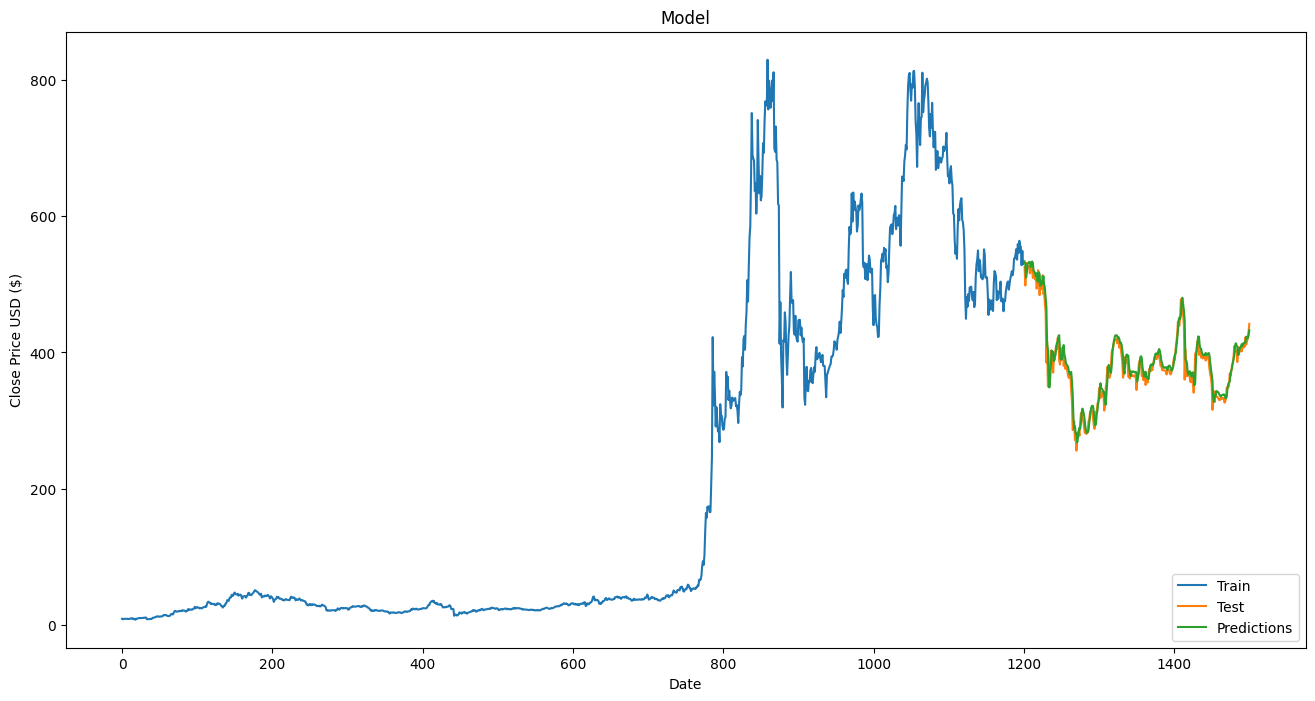

In [ ]:
data = data.filter(['close'])
train = data[:training_data_total]
test = data[training_data_total:]
test['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(test[['close', 'Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()

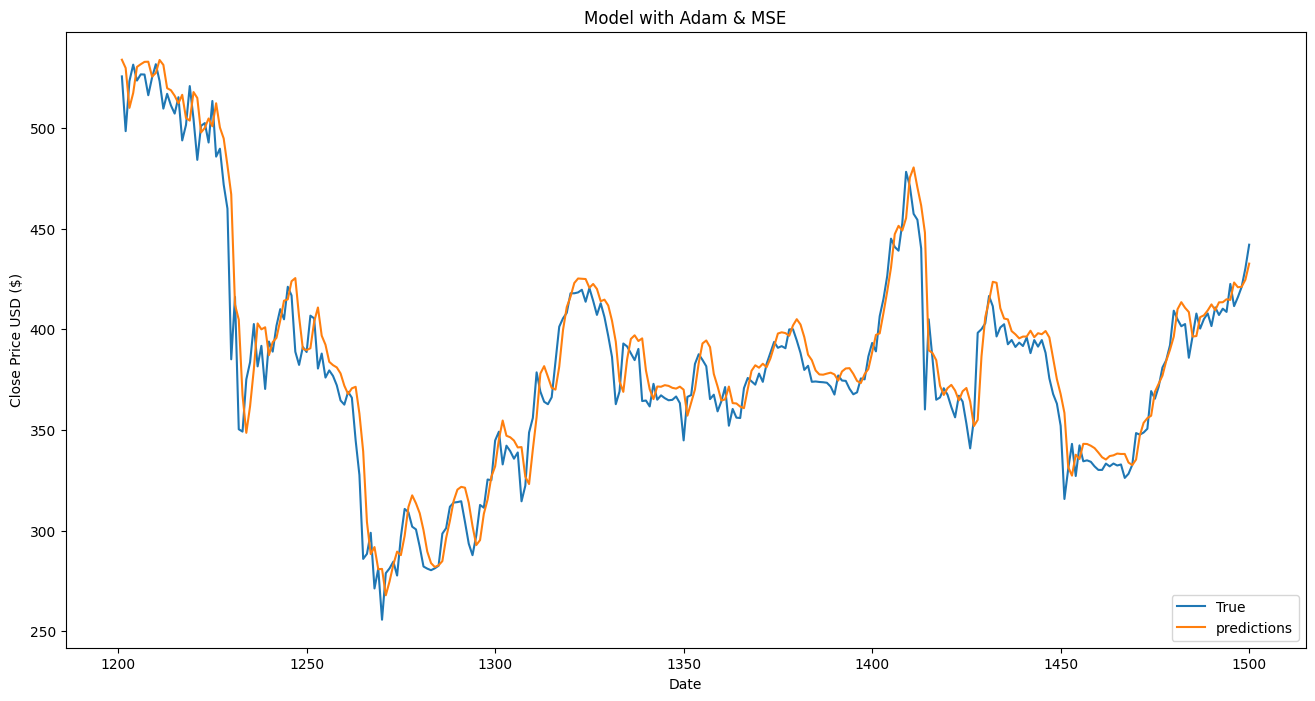

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Model with Adam & MSE')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
# plt.plot(train)
plt.plot(test[['close', 'Predictions']])
plt.legend([ 'True', 'predictions'], loc='lower right')
plt.show()

In [ ]:
## now if we change loss function to mae and other conditions keep same

model_1a = tf.keras.Sequential()

########.  TEST 1a - LSTM(100) with loss function: mae
# activation function = tanh as default below
model_1a.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model_1a.add(LSTM(100, return_sequences=False))
model_1a.add(Dense(25)) # a hidden layer with 25 nodes, 
model_1a.add(Dense(1)) # since we want a single continuous output
model_1a.summary()

model_1a.compile(optimizer='adam', loss='mean_absolute_error')
model_1a.fit(x_train, y_train, batch_size= 1, epochs=3)

predictions_1a = model_1a.predict(x_test)
predictions_1a = scaler.inverse_transform(predictions_1a)
rmse = np.sqrt(np.mean(predictions_1a - y_test)**2)
mse = mean_squared_error(y_test, predictions_1a)


print(f'Mean Squared Error is {mse}')
print(f'rmse is {rmse}')  


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 60, 100)           40800     
                                                                 
 lstm_35 (LSTM)              (None, 100)               80400     
                                                                 
 dense_34 (Dense)            (None, 25)                2525      
                                                                 
 dense_35 (Dense)            (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
1141/1141 [==============================] - 13s 8ms/step - loss: 0.0394
Epoch 2/3
1141/1141 [==============================] - 8s 7ms/step - loss: 0.0269
Epoch 3/3
10/1

<ipython-input-169-1d0052e972db>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test['Predictions'] = predictions_1a


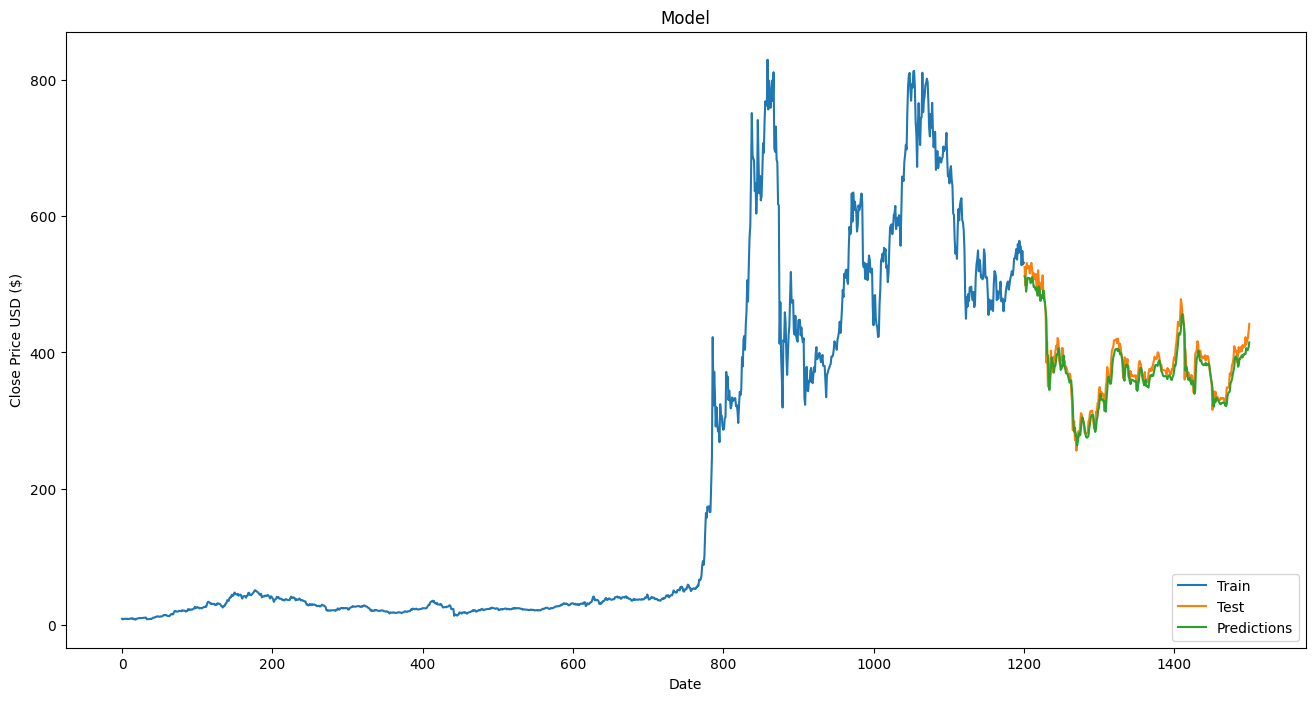

In [ ]:
data = data.filter(['close'])
train = data[:training_data_total]
Test = data[training_data_total:]
Test['Predictions'] = predictions_1a
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(Test[['close', 'Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()

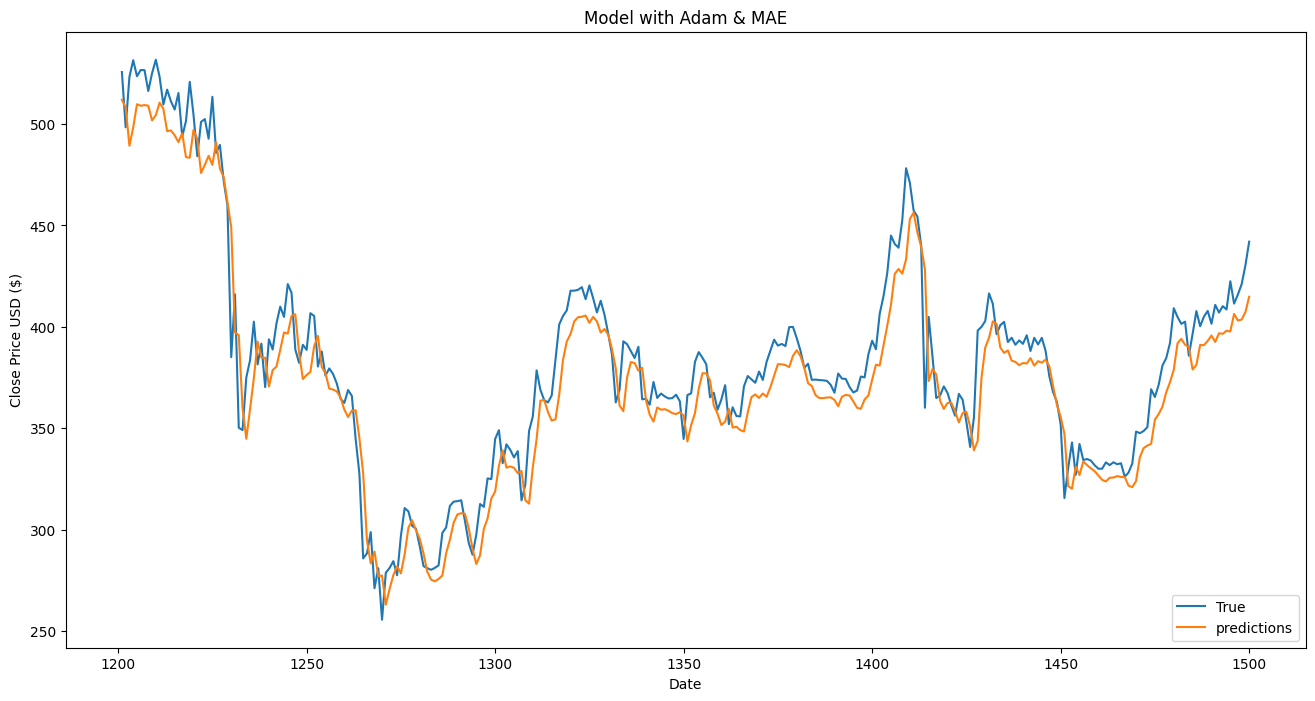

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Model with Adam & MAE')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
# plt.plot(train)
plt.plot(Test[['close', 'Predictions']])
plt.legend([ 'True', 'predictions'], loc='lower right')
plt.show()

As the plots and rse shown above, we can see mse performance better than mae

model2 - change to lstm(50)

In [ ]:
# Then create a Sequential model and add layers one at a time to check
model2 = tf.keras.Sequential()
########.  TEST 2 - LSTM(50) with loss function mse
# activation function = tanh as default below
model2.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model2.add(LSTM(50, return_sequences=False))
model2.add(Dense(25))
model2.add(Dense(1)) # since we want a single continuous output
model2.summary()

model2.compile(optimizer='adam', loss='mean_squared_error')
model2.fit(x_train, y_train, batch_size= 1, epochs=3)

predictions2 = model2.predict(x_test)
predictions2 = scaler.inverse_transform(predictions2)
rmse = np.sqrt(np.mean(predictions2 - y_test)**2)
mse = mean_squared_error(y_test, predictions2)


print(f'Mean Squared Error is {mse}')
print(f'rmse is {rmse}')


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 60, 50)            10400     
                                                                 
 lstm_33 (LSTM)              (None, 50)                20200     
                                                                 
 dense_32 (Dense)            (None, 25)                1275      
                                                                 
 dense_33 (Dense)            (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
1141/1141 [==============================] - 18s 13ms/step - loss: 0.0043
Epoch 2/3
1141/1141 [==============================] - 15s 13ms/step - loss: 0.0020
Epoch 3/3
10/

<ipython-input-160-47ed12219bb1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions2


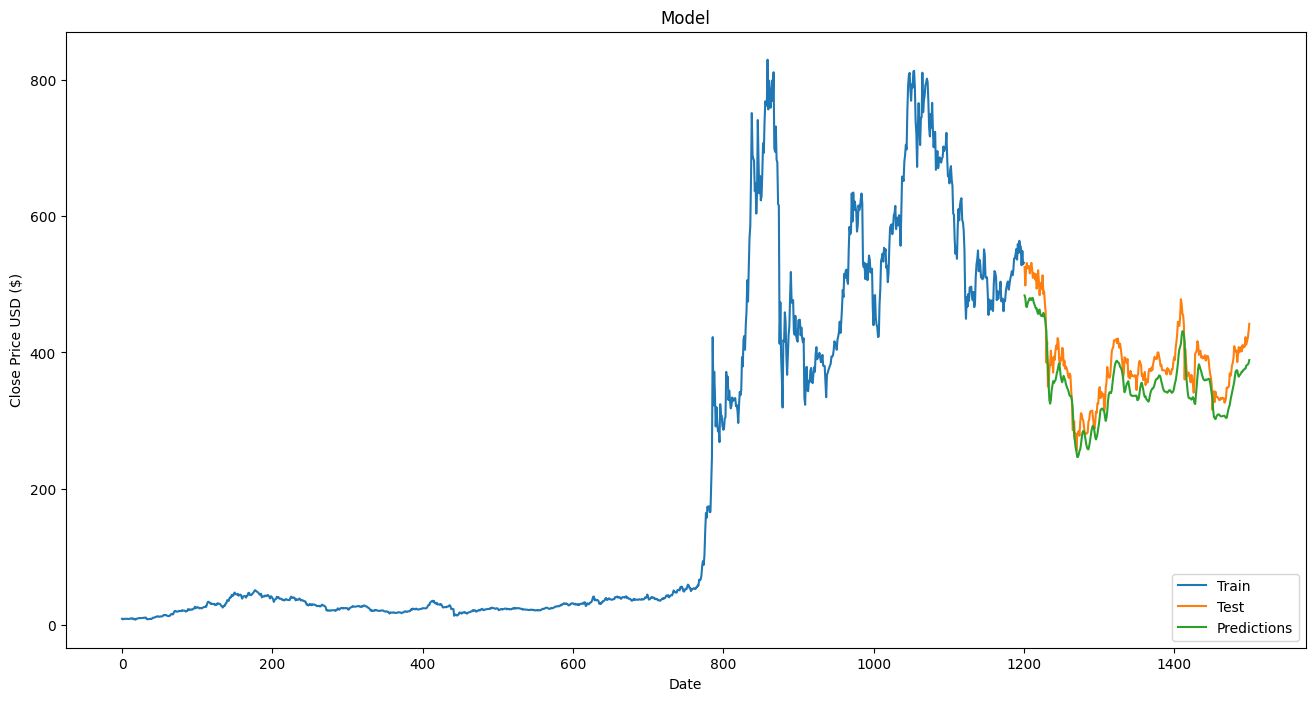

In [ ]:
data = data.filter(['close'])
train = data[:training_data_total]
test = data[training_data_total:]
test['Predictions'] = predictions2
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(test[['close', 'Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
test.head(20)

,close,Predictions
1201,525.58,483.746429
1202,498.38,479.594116
1203,523.24,467.967377
1204,531.42,466.604462
1205,523.51,471.782166
1206,526.58,475.036346
1207,526.51,477.987762
1208,516.22,479.903381
1209,524.98,477.359070
1210,531.65,477.197144


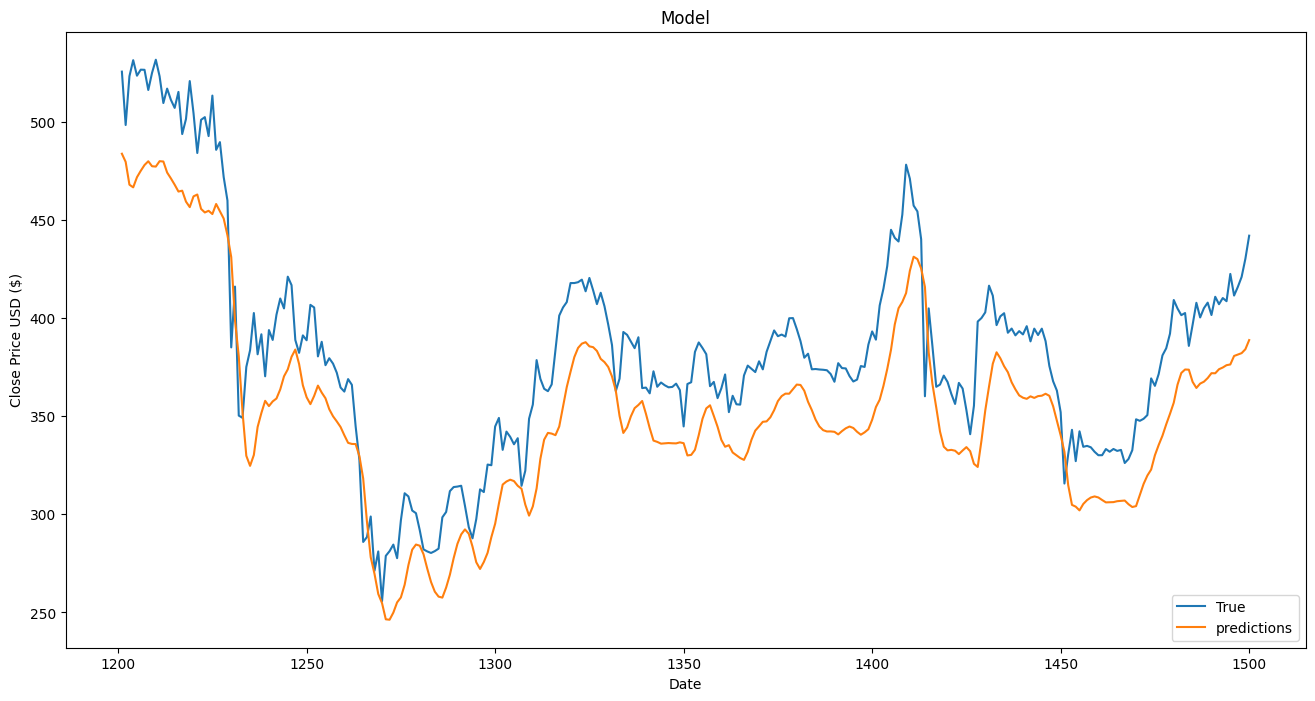

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
# plt.plot(train)
plt.plot(test[['close', 'Predictions']])
plt.legend([ 'True', 'predictions'], loc='lower right')
plt.show()

In [ ]:
# Then create a Sequential model and add layers one at a time to check
model2b = tf.keras.Sequential()
########.  TEST 2 - LSTM(50) with loss function mse
# activation function = tanh as default below
model2b.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model2b.add(LSTM(50, return_sequences=False))
model2b.add(Dense(25))
model2b.add(Dense(1)) # since we want a single continuous output
model2b.summary()

model2b.compile(optimizer='adam', loss='mean_absolute_error')
model2b.fit(x_train, y_train, batch_size= 1, epochs=3)

predictions2b = model2b.predict(x_test)
predictions2b = scaler.inverse_transform(predictions2b)
rmse = np.sqrt(np.mean(predictions2b - y_test)**2)
mse = mean_squared_error(y_test, predictions2b)


print(f'Mean Squared Error is {mse}')
print(f'rmse is {rmse}')

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 60, 50)            10400     
                                                                 
 lstm_19 (LSTM)              (None, 50)                20200     
                                                                 
 dense_18 (Dense)            (None, 25)                1275      
                                                                 
 dense_19 (Dense)            (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
1141/1141 [==============================] - 12s 7ms/step - loss: 0.0368
Epoch 2/3
1141/1141 [==============================] - 8s 7ms/step - loss: 0.0256
Epoch 3/3
10/10 [

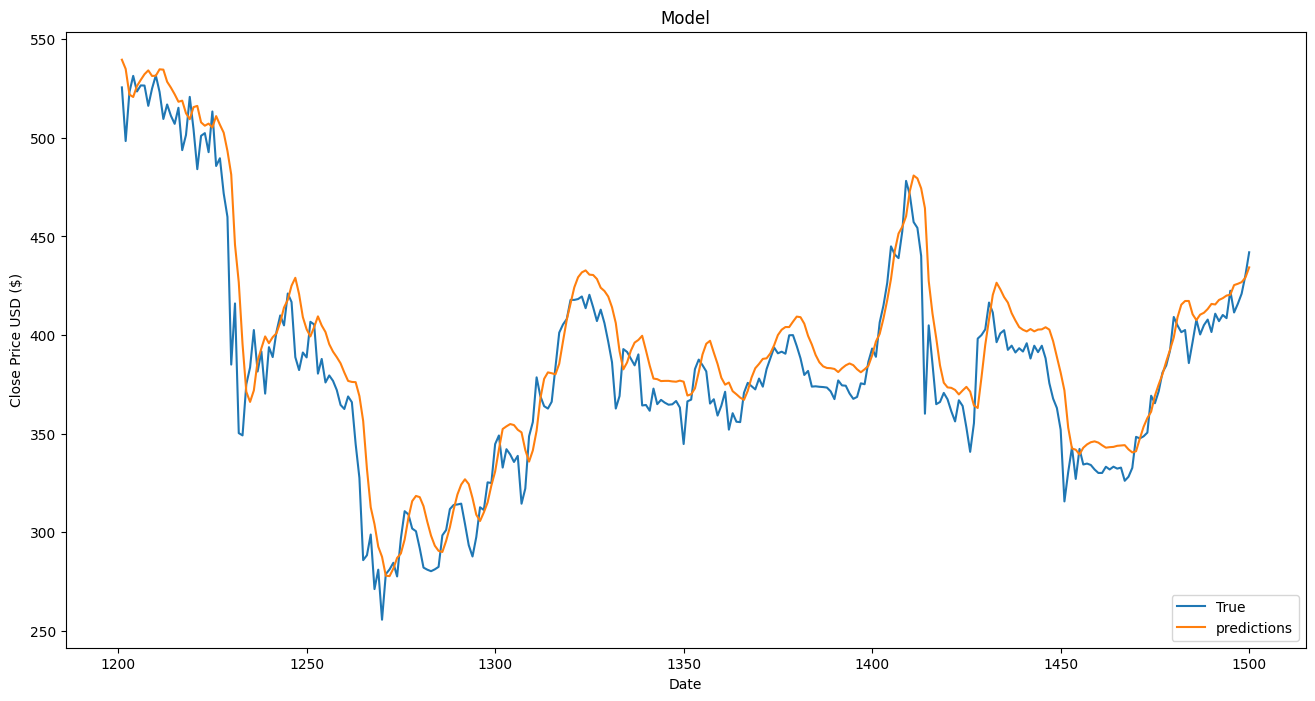

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
# plt.plot(train)
plt.plot(test[['close', 'Predictions']])
plt.legend([ 'True', 'predictions'], loc='lower right')
plt.show()

Usually more units cause overfitting, in our case, why LSTM(50) performance better, which means units=100 may overfit in train datset

<ipython-input-48-4ebcd4cc14d0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions2b


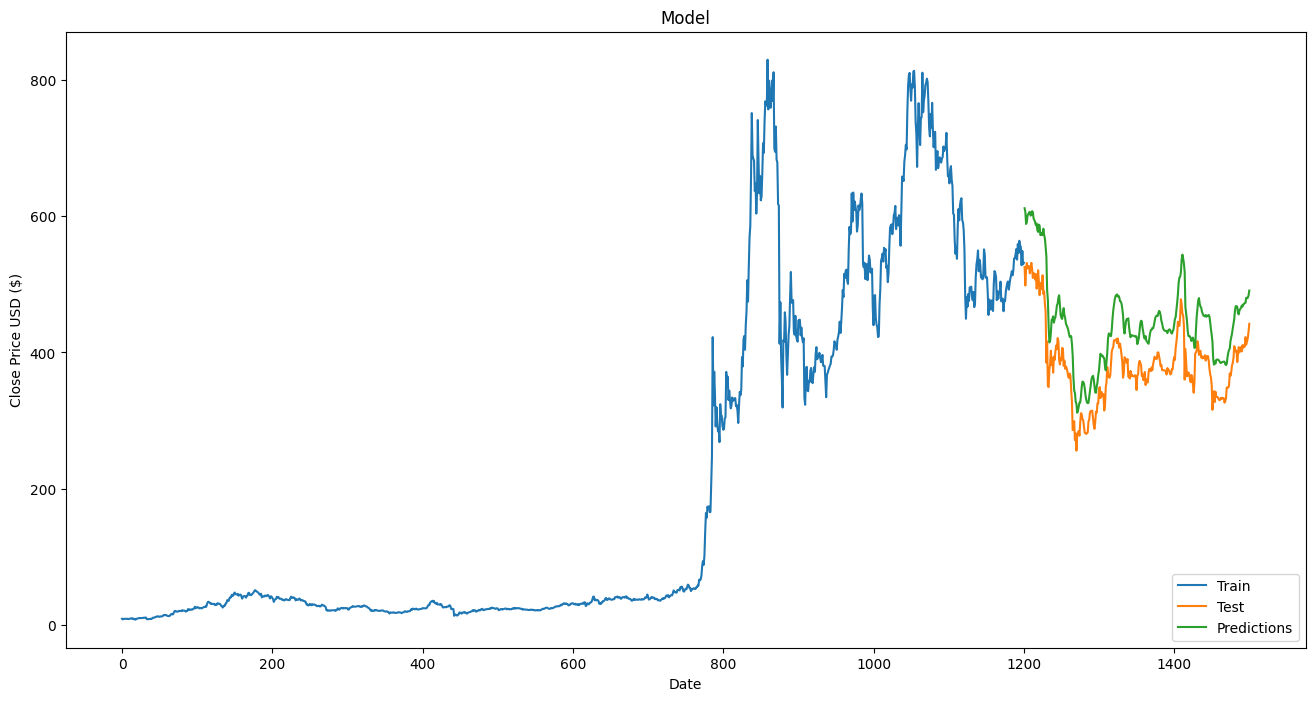

In [ ]:
data = data.filter(['close'])
train = data[:training_data_total]
test = data[training_data_total:]
test['Predictions'] = predictions2b
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(test[['close', 'Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
test.head(10)

,close,Predictions
1201,525.58,611.889771
1202,498.38,606.868042
1203,523.24,588.684387
1204,531.42,591.846863
1205,523.51,601.517517
1206,526.58,603.496094
1207,526.51,605.510559
1208,516.22,606.551208
1209,524.98,600.998474
1210,531.65,602.188965


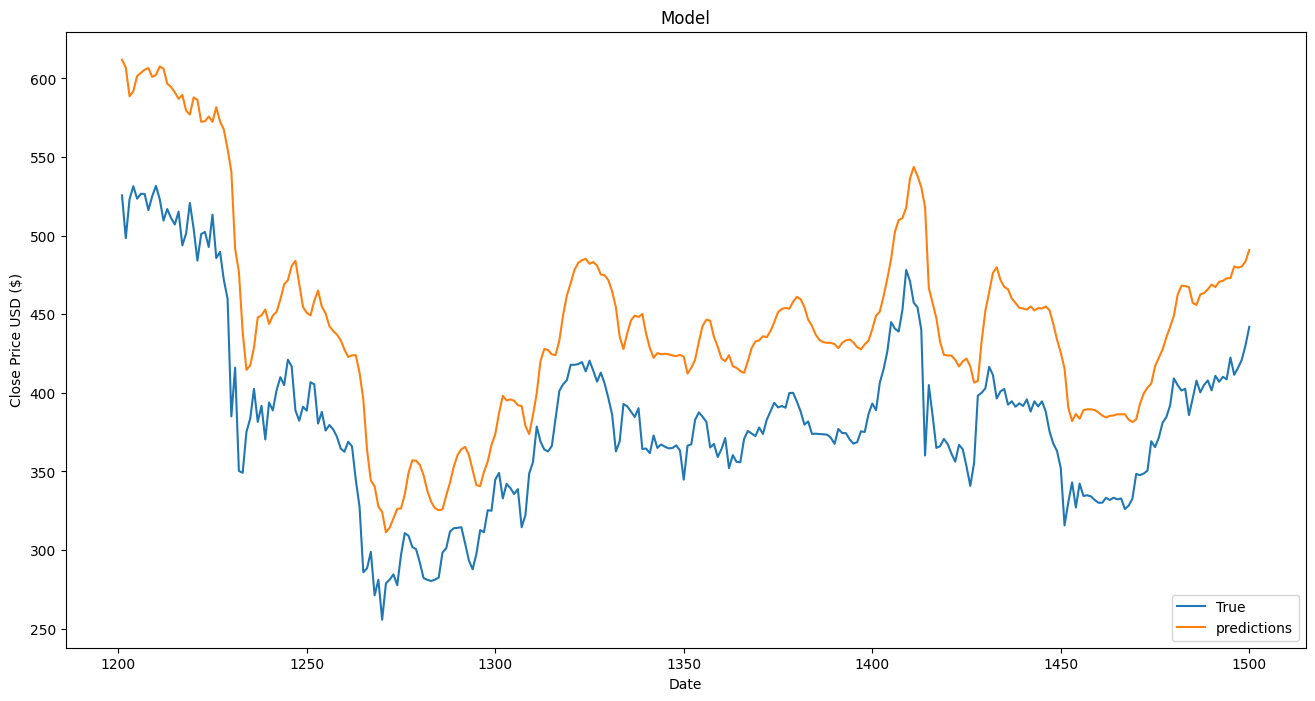

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
# plt.plot(train)
plt.plot(test[['close', 'Predictions']])
plt.legend([ 'True', 'predictions'], loc='lower right')
plt.show()

loss function, we use MSE is better than MAE and LSTM(50) is a better choice with lowest mse with adam optimizer

Then i'll try another optimizer - SGD: Gradient descent with momentum optimizer.

In [ ]:
# Then create a Sequential model and add layers one at a time to check
model_SGD1 = tf.keras.Sequential()

########.  TEST 1 - LSTM(100)
# activation function = tanh as default below
model_SGD1.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model_SGD1.add(LSTM(100, return_sequences=False))
model_SGD1.add(Dense(25))
model_SGD1.add(Dense(1)) # since we want a single continuous output
model_SGD1.summary()

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
model_SGD1.compile(optimizer=optimizer, loss='mean_squared_error')

model_SGD1.fit(x_train, y_train, batch_size= 1, epochs=3)

predictions = model_SGD1.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
mse = mean_squared_error(y_test, predictions)


print(f'Mean Squared Error is {mse}')
print(f'rmse is {rmse}')


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 60, 100)           40800     
                                                                 
 lstm_37 (LSTM)              (None, 100)               80400     
                                                                 
 dense_36 (Dense)            (None, 25)                2525      
                                                                 
 dense_37 (Dense)            (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
1141/1141 [==============================] - 11s 7ms/step - loss: 0.0100
Epoch 2/3
1141/1141 [==============================] - 8s 7ms/step - loss: 0.0030
Epoch 3/3
10/1

<ipython-input-173-ac4bded34bd3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


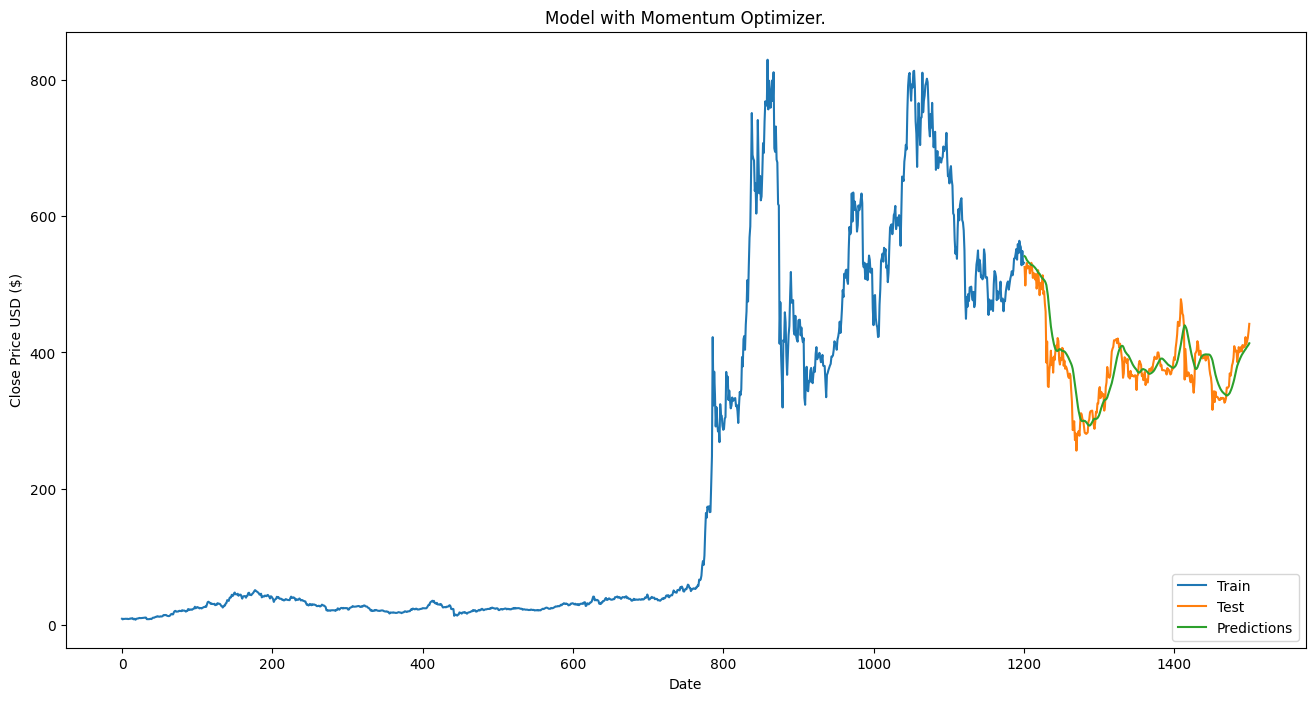

In [ ]:
data = data.filter(['close'])
train = data[:training_data_total]
test = data[training_data_total:]
test['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model with Momentum Optimizer.')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(test[['close', 'Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()

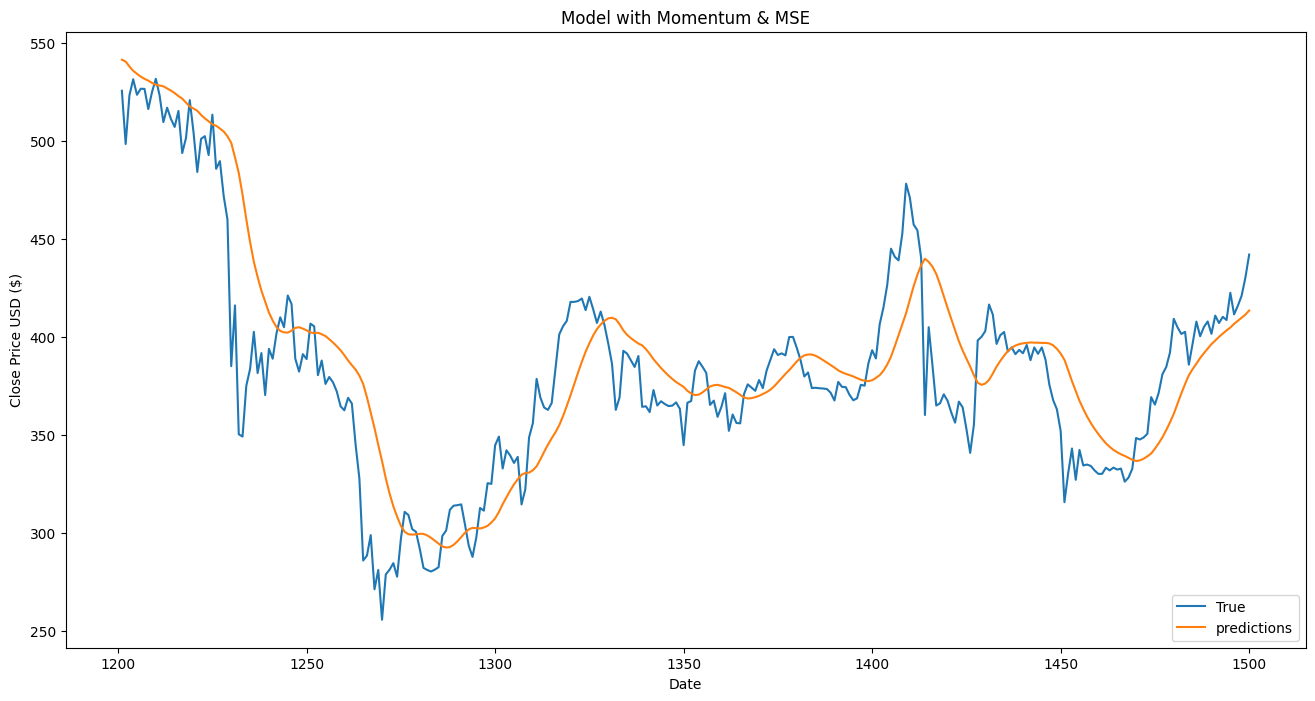

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Model with Momentum & MSE')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
# plt.plot(train)
plt.plot(test[['close', 'Predictions']])
plt.legend([ 'True', 'predictions'], loc='lower right')
plt.show()

In [ ]:
# Then create a Sequential model and add layers one at a time to check
model_SGD2 = tf.keras.Sequential()

########.  TEST 1 - LSTM(100)
# activation function = tanh as default below
model_SGD2.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model_SGD2.add(LSTM(50, return_sequences=False))
model_SGD2.add(Dense(25))
model_SGD2.add(Dense(1)) # since we want a single continuous output
model_SGD2.summary()

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.8)
model_SGD2.compile(optimizer=optimizer, loss='mean_squared_error')

model_SGD2.fit(x_train, y_train, batch_size= 1, epochs=3)

predictions = model_SGD2.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
mse = mean_squared_error(y_test, predictions)


print(f'Mean Squared Error is {mse}')
print(f'rmse is {rmse}')

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 60, 50)            10400     
                                                                 
 lstm_23 (LSTM)              (None, 50)                20200     
                                                                 
 dense_22 (Dense)            (None, 25)                1275      
                                                                 
 dense_23 (Dense)            (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
1141/1141 [==============================] - 11s 7ms/step - loss: 0.0189
Epoch 2/3
1141/1141 [==============================] - 8s 7ms/step - loss: 0.0030
Epoch 3/3
10/10 

<ipython-input-54-2daca1eaf33d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


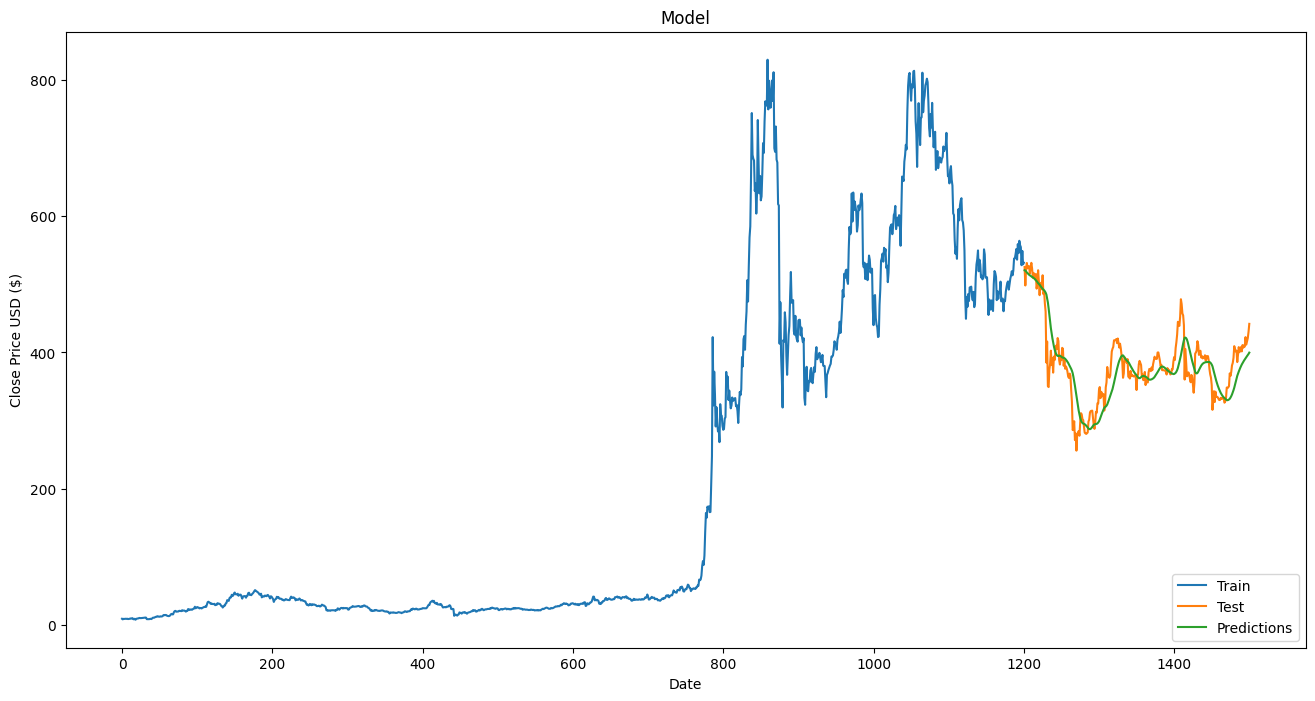

In [ ]:
data = data.filter(['close'])
train = data[:training_data_total]
test = data[training_data_total:]
test['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(test[['close', 'Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
## i'm thinking there may be overfitting - seems the data fit well. Then i'll provide another csv file to test - from 2023-02-02 to 2023-04-01

uploaded = files.upload()


Saving datasci3ml_final_project_test.csv to datasci3ml_final_project_test.csv


In [ ]:
test_new = pd.read_csv(io.BytesIO(uploaded['datasci3ml_final_project_test.csv']))
print(test_new.head(5))
print(test_new.shape)
new_data_test = test_new[-120:]
new_data_test.head(5)

         time   high    low   open  volumefrom    volumeto  close
0  2018-12-23  9.456  8.310  9.072   120813.98  1086123.17  8.990
1  2018-12-24  8.541  8.021  8.990    79032.72   641233.75  8.114
2  2018-12-25  8.795  8.326  8.114    39077.02   337540.36  8.638
3  2018-12-26  7.930  7.373  8.638    69245.38   538902.78  7.783
4  2018-12-27  9.458  8.401  7.783    99151.86   845665.28  8.529
(1561, 7)


,time,high,low,open,volumefrom,volumeto,close
1441,2022-12-03,403.51,390.41,391.19,39401.32,15498219.07,393.34
1442,2022-12-04,395.57,389.58,392.44,49247.74,19287918.12,391.65
1443,2022-12-05,402.11,395.69,390.89,27215.63,10773591.27,395.86
1444,2022-12-06,390.14,382.91,395.86,32857.76,12752747.57,388.12
1445,2022-12-07,398.13,392.74,387.66,45729.22,18045415.03,394.61


In [ ]:
# first, we still want to scale the dataset
test_new_scaled = scaler.transform(new_data_test['close'].values.reshape(-1, 1))


x_test_new = []
y_test_new = new_data_test['close'].values
print(len(y_test_new)) ### 2023-02-03 starts from the last 59 row
for i in range(60, len(test_new_scaled)):
  x_test_new.append(test_new_scaled[i-60:i, 0])

x_test_new = np.array(x_test_new)
x_test_new = np.reshape(x_test_new, (x_test_new.shape[0], x_test_new.shape[1], 1))

# then we will use model to make a prediction as model permormance better above
predictions_newtest = model.predict(x_test_new) 

# Inverse scale the predictions to get the actual stock prices
predictions_newtest = scaler.inverse_transform(predictions_newtest)


120
2/2 [==============================] - 0s 69ms/step


In [ ]:

rmse = np.sqrt(np.mean(predictions_newtest - y_test_new)**2)

print(f'Mean Squared Error is {mse}')
# print(f'rmse is {rmse}')

Mean Squared Error is 226.868629781929


In [ ]:
print(pd.DataFrame(predictions_newtest).head(5))
new_data = new_data_test[60:]
new_data['predictions'] = predictions_newtest
new_data.head(10)

            0
0  424.580811
1  432.570892
2  446.347931
3  450.406952
4  449.221252


<ipython-input-22-b76e606d78f8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['predictions'] = predictions_newtest


,time,high,low,open,volumefrom,volumeto,close,predictions
1501,2023-02-01,437.02,414.50,420.97,77902.99,33516999.87,430.24,424.580811
1502,2023-02-02,447.36,426.95,430.04,99811.31,44431971.64,445.16,432.570892
1503,2023-02-03,446.85,436.60,444.39,46866.01,20701802.27,441.72,446.347931
1504,2023-02-04,442.24,431.96,441.72,61481.54,27068716.66,440.27,450.406952
1505,2023-02-05,439.12,432.59,440.27,49109.41,21458034.39,436.94,449.221252
1506,2023-02-06,453.59,444.61,436.94,48937.26,21878796.99,447.08,445.070160
1507,2023-02-07,442.62,434.86,447.08,53004.93,23378758.32,441.07,449.143555
1508,2023-02-08,414.84,404.64,441.07,53656.36,22136108.38,412.55,447.810211
1509,2023-02-09,412.76,399.38,412.55,45233.68,18532931.18,409.72,427.611938
1510,2023-02-10,415.78,411.70,408.96,31086.02,12870486.48,414.03,414.577667


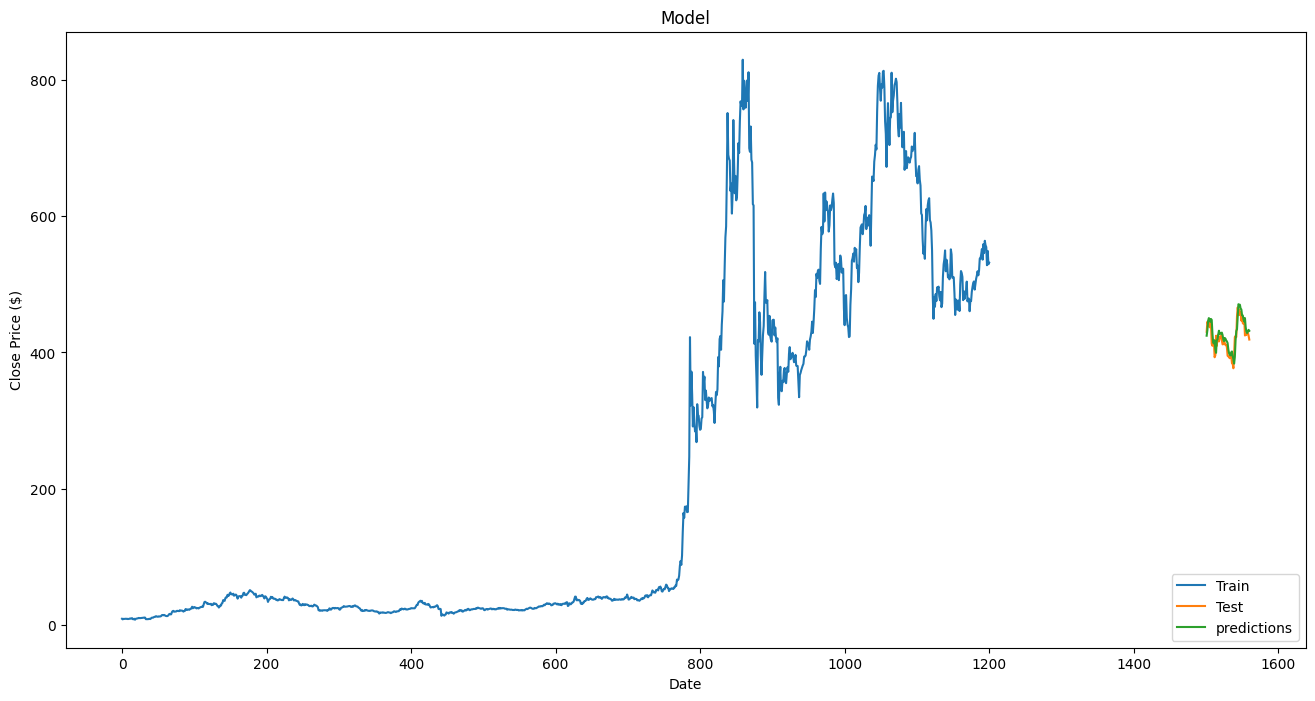

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.plot(train)
plt.plot(new_data[['close', 'predictions']])
plt.legend(['Train', 'Test', 'predictions'], loc='lower right')
plt.show()

# since we use train to test a new test set, so there's a missing gap - makes sense. 

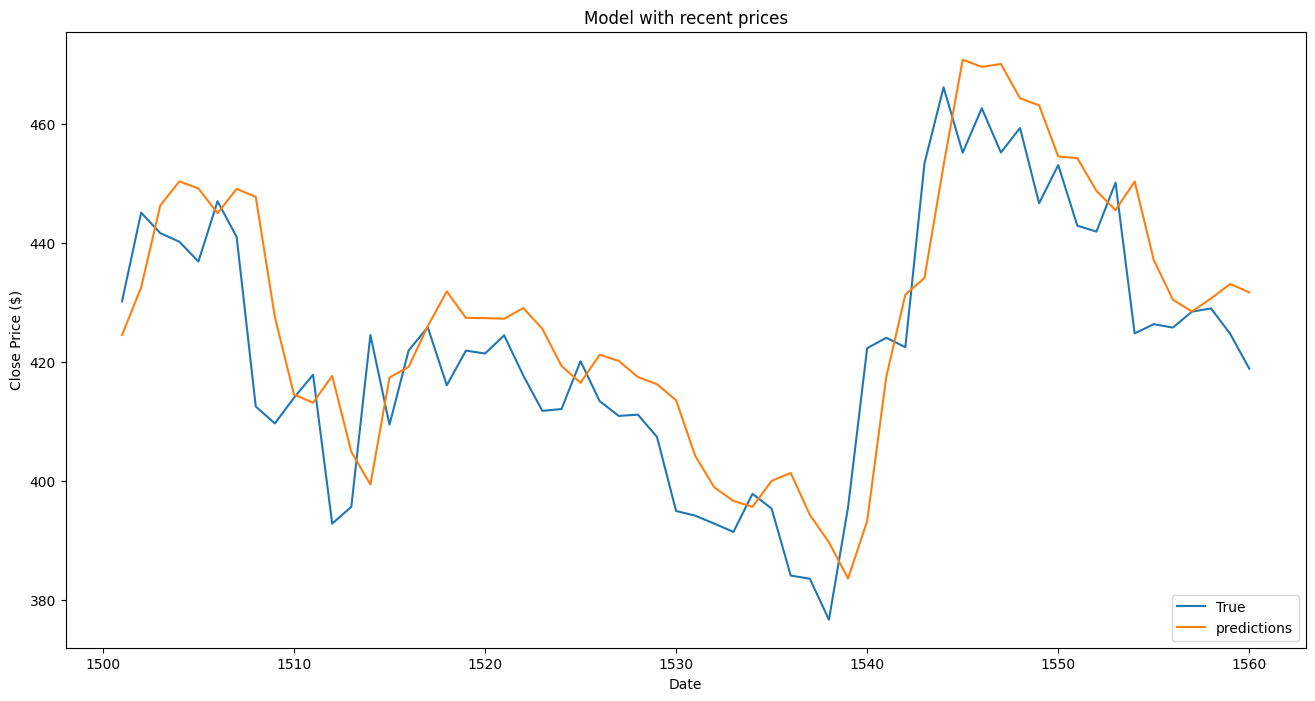

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Model with recent prices')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
# plt.plot(train)
plt.plot(new_data[['close', 'predictions']])
plt.legend([ 'True', 'predictions'], loc='lower right')
plt.show()


MSE may change when rerun the codes, as model weights are randomly initialized 

In [ ]:
######################

Then we can try ARIMA model - based on the concepts learned in time series class, i'll check stationary, do the log and then fit arima model

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# close_prices is our feature here

#Ho: it is non-stationary vs. Ha: it is stationary

adf_test = adfuller(close_prices) # adf, p-value,# of Lags, # of Observations, CI
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')
for key, value in adf_test[4].items():
    print('Critial Values:')
    print(f'{key}, {value}')
print(f' -----   Then based on the p-value {adf_test[1]} provided above, which is larger than 0.05, then we fail to reject H0 and conclude it is nonstationary')

ADF Statistic: -1.4635891669221626
p-value: 0.5514402669875196
Critial Values:
1%, -3.4347881497897688
Critial Values:
5%, -2.8635001537551923
Critial Values:
10%, -2.567813565797108
 -----   Then based on the p-value 0.5514402669875196 provided above, which is larger than 0.05, then we fail to reject H0 and conclude it is nonstationary


In [ ]:
# Then we want to do the difference and check whether it's stationary again - difference till we get stationary series
data['close']
data['close first difference'] = data['close'] - data['close'].shift(1)

first_dif_adf = adfuller(data['close first difference'].dropna())
print(f'ADF Statistic: {first_dif_adf[0]}')
print(f'p-value: {first_dif_adf[1]}')
for key, value in first_dif_adf[4].items():
    print('Critial Values:')
    print(f'{key}, {value}')
if first_dif_adf[1] < 0.05:
  print('Then we will reject H0 in favor of Ha and conclude that it is stationary' )

ADF Statistic: -7.10976108566437
p-value: 3.967075986243283e-10
Critial Values:
1%, -3.434791163965702
Critial Values:
5%, -2.8635014840083945
Critial Values:
10%, -2.5678142741740877
Then we will reject H0 in favor of Ha and conclude that it is stationary


<Axes: >

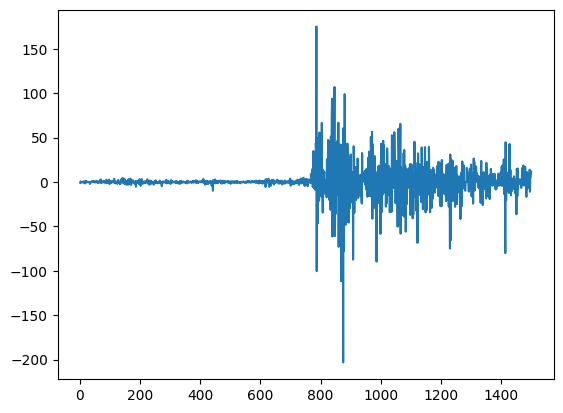

In [ ]:
data['close first difference'] .plot() # we can see the pattern is still unstable, variance becomes large as time goes by
# then we'll try log(difference) to see whether it's better

In [ ]:
data['log_close'] = np.log(data['close'])
data['log_close_first_difference'] = data['log_close'] - data['log_close'].shift(1)
data.head(2)

,Unnamed: 0,time,high,low,open,volumefrom,volumeto,close,close first difference,log_close,log_close_first_difference
0,0,2018-12-25,8.795,8.326,8.114,39077.02,337540.36,8.638,NaN,2.156171,NaN
1,1,2018-12-26,7.930,7.373,8.638,69245.38,538902.78,7.783,-0.855,2.051942,-0.104229


ADF Statistic: -17.747777545065233
p-value: 3.38035540193931e-30
Critial Values:
1%, -3.4347287139577753
Critial Values:
5%, -2.8634739225299133
Critial Values:
10%, -2.5677995973755325
Then we will reject H0 in favor of Ha and conclude that it is stationary


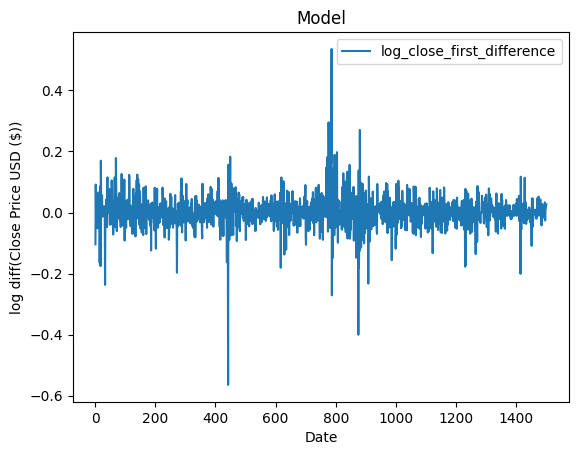

In [ ]:
log_first_dif_adf = adfuller(data['log_close_first_difference'].dropna())
print(f'ADF Statistic: {log_first_dif_adf[0]}')
print(f'p-value: {log_first_dif_adf[1]}')
for key, value in log_first_dif_adf[4].items():
    print('Critial Values:')
    print(f'{key}, {value}')
if log_first_dif_adf[1] < 0.05:
  print('Then we will reject H0 in favor of Ha and conclude that it is stationary' )

data['log_close_first_difference'].plot()
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('log diff(Close Price USD ($))')
# plt.plot(train)
plt.legend()

# this plot seems much more stable

Then i'll check acf and pacf for log_first_difference 

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


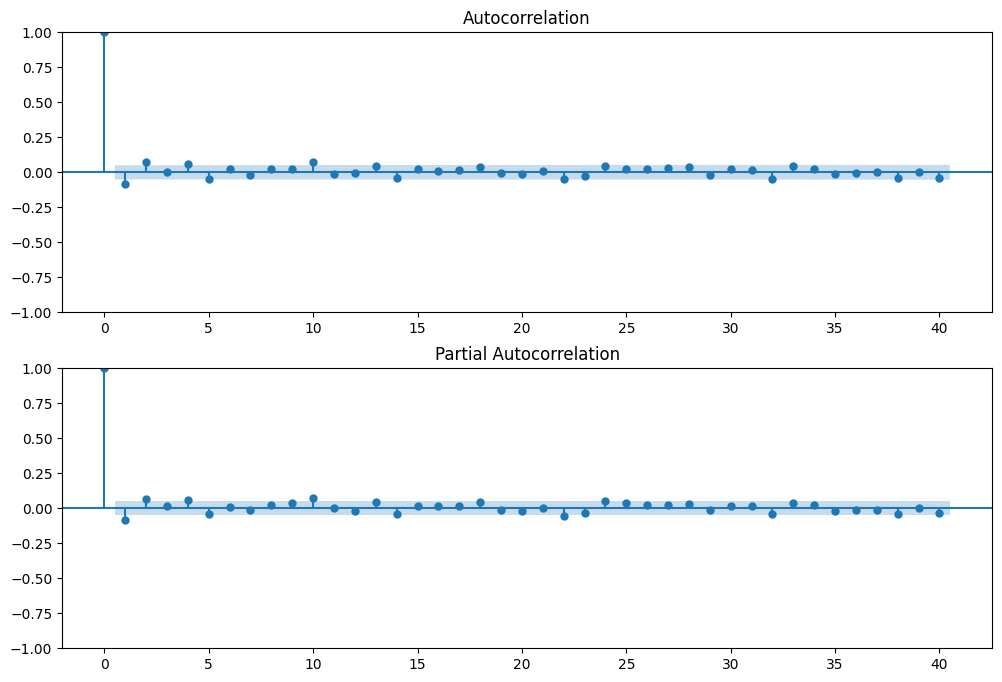

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data['log_close_first_difference'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data['log_close_first_difference'].dropna(),lags=40,ax=ax2)

In [ ]:
# from the plot, we can find 0 is significant in both plots, then we may assme it's arma(0,0), that means log(close) may be arima(0,1,0) model

# below, we'll try to predict log(close_prices) instead of close price

data.head(2)
log_close_values = data['log_close'].values
train = log_close_values[0:1201]
test = log_close_values[1201:]

In [ ]:
from pmdarima.arima import auto_arima
model_arima = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model_arima.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3474.576, Time=1.97 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3463.103, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3468.472, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3467.596, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3460.767, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3472.669, Time=2.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3469.580, Time=0.44 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-3472.957, Time=2.09 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-3470.553, Time=2.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3474.649, Time=1.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3471.011, Time=0.35 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3471.413, Time=0.65 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3471.915, Time=0.41 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 12.659 seconds


ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True)

Then we get the best models may be ARIMA(1,1,1), ARIMA(0,0,0) and the one we get by eyes ARIMA(0,1,0)

In [ ]:
data

,Unnamed: 0,time,high,low,open,volumefrom,volumeto,close,close first difference,log_close,log_close_first_difference
0,0,2018-12-25,8.795,8.326,8.114,39077.02,337540.36,8.638,NaN,2.156171,NaN
1,1,2018-12-26,7.930,7.373,8.638,69245.38,538902.78,7.783,-0.855,2.051942,-0.104229
2,2,2018-12-27,9.458,8.401,7.783,99151.86,845665.28,8.529,0.746,2.143472,0.091530
3,3,2018-12-28,8.765,8.055,8.529,107160.55,901018.53,8.408,-0.121,2.129184,-0.014288
4,4,2018-12-29,8.737,8.451,8.408,53664.29,461631.08,8.602,0.194,2.151995,0.022811
...,...,...,...,...,...,...,...,...,...,...,...
1496,1496,2023-01-29,412.690,401.980,421.480,63638.22,26184957.28,411.470,-11.010,6.019736,-0.026406
1497,1497,2023-01-30,422.650,411.870,411.680,35867.33,14916777.79,415.890,4.420,6.030421,0.010685
1498,1498,2023-01-31,432.740,419.880,415.890,41991.07,17677112.59,420.970,5.080,6.042562,0.012141
1499,1499,2023-02-01,437.020,414.500,420.970,77902.99,33516999.87,430.240,9.270,6.064343,0.021782


In [ ]:
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1201
Model:               SARIMAX(1, 1, 1)   Log Likelihood                1741.324
Date:                Tue, 18 Apr 2023   AIC                          -3474.649
Time:                        01:19:40   BIC                          -3454.289
Sample:                             0   HQIC                         -3466.979
                               - 1201                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0062      0.003      2.158      0.031       0.001       0.012
ar.L1         -0.8157      0.072    -11.323      0.000      -0.957      -0.675
ma.L1          0.7495      0.080      9.400      0.000       0.593       0.906
sigma2         0.0032   4.09e-05     78.547      0.000       0.003       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             17438.96
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.33   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
new_data_log = data[['time', 'log_close']]
new_data_log

train = new_data_log[0:1201]
test = new_data_log[1201:]
print(test.head(2))
train.tail(2)

            time  log_close
1201  2022-04-09   6.264502
1202  2022-04-10   6.211363


,time,log_close
1199,2022-04-07,6.272046
1200,2022-04-08,6.276512


In [ ]:
predictions, conf = model_arima.predict(n_periods=len(test), return_conf_int=True)
test = pd.DataFrame(test, columns = ['time','log_close'])
test['predictions'] = predictions
test

predictions = pd.DataFrame(predictions,index = test.index,columns=['Prediction'])
test

,time,log_close,predictions
1201,2022-04-09,6.264502,6.274072
1202,2022-04-10,6.211363,6.282297
1203,2022-04-11,6.260040,6.281822
1204,2022-04-12,6.275553,6.288443
1205,2022-04-13,6.260556,6.289276
...,...,...,...
1496,2023-01-29,6.019736,7.289576
1497,2023-01-30,6.030421,7.293009
1498,2023-01-31,6.042562,7.296443
1499,2023-02-01,6.064343,7.299876


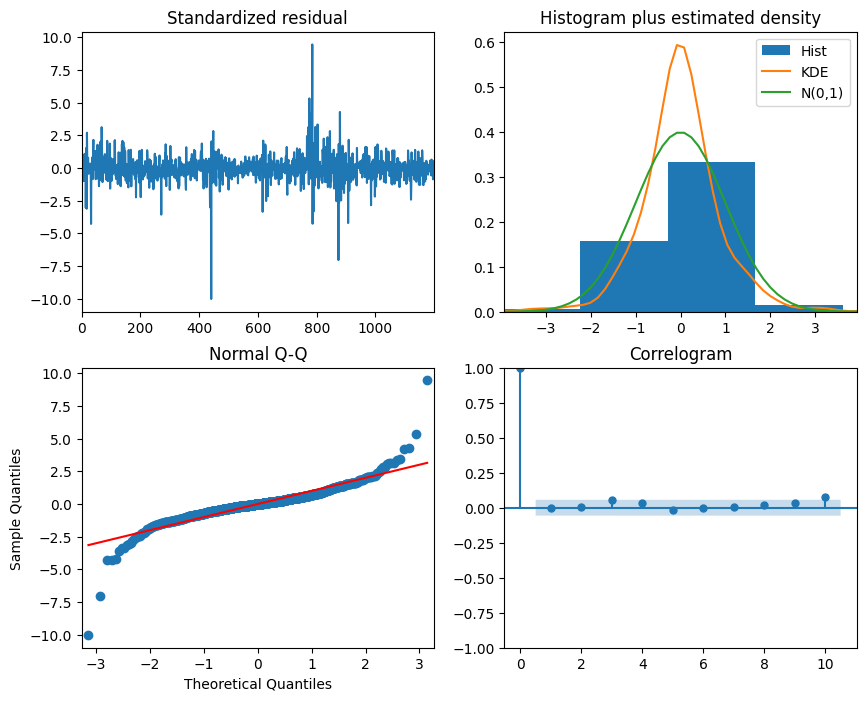

In [ ]:
model_arima.plot_diagnostics(figsize=(10,8))
plt.show()

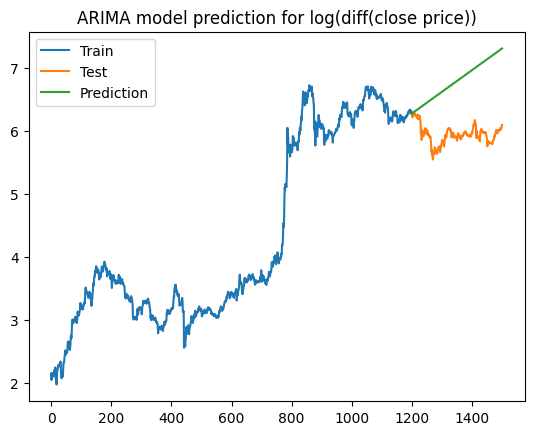

In [ ]:
#plot the predictions for validation set
plt.plot(train.log_close, label='Train')
plt.plot(test.log_close, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('ARIMA model prediction for log(diff(close price))')
plt.legend()
plt.show()

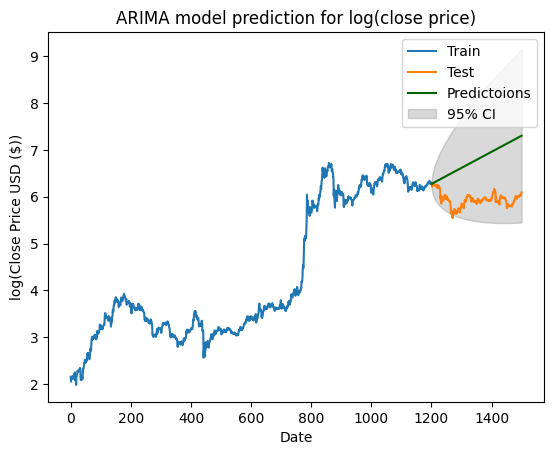

In [ ]:

fc, confint = model_arima.predict(n_periods=len(test), return_conf_int=True)
index_of_fc = np.arange(len(train.log_close), len(train.log_close)+len(test))

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(train.log_close, label='Train')
plt.plot(test.log_close, label='Test')

plt.plot(fc_series, color='darkgreen', label = 'Predictoions')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15, label = '95% CI')
plt.title('ARIMA model prediction for log(close price)')
plt.xlabel('Date')
plt.ylabel('log(Close Price USD ($))')
plt.legend()
plt.show()

Obviously time series ARIMA model is not too good, although it's still in 95% CI. Then we can conclude that LSTM is much better than ARIMA model for this case. This is because test has length 300 days, which is large, that means ARIMA model is not good to long-term prediction as it can only gives an average trend.

In [ ]:
# cost function                                      